In [ ]:
# @title 1. Environment Setup (Decoupled Logic)
import sys
import os
import subprocess

# --- 1. Install System Drivers & ModernGL ---
# We check this independently so we don't trigger a numpy reinstall unnecessarily.
try:
    import moderngl
    print("[INFO] ModernGL is already installed.")
except ImportError:
    print("[*] Installing graphics drivers and ModernGL...")
    !apt-get update -qq
    !apt-get install -y -qq libegl1-mesa libgl1-mesa-dri libxcb-xfixes0-dev mesa-vulkan-drivers
    !pip install -q moderngl
    print("[INFO] ModernGL installation complete.")

# --- 2. Numpy Version Check (The Loop Breaker) ---
# We ONLY touch numpy if it is the wrong version (2.x).
import numpy as np
print(f"[INFO] Current Numpy Version: {np.__version__}")

if np.__version__.startswith("2"):
    print("[!] Numpy 2.x detected! Downgrading to 1.x...")
    !pip uninstall -y numpy
    !pip install "numpy<2.0"
    print("-------------------------------------------------------------------")
    print(" [!] IMPORTANT: RESTART SESSION NOW (Runtime > Restart Session).")
    print("     Then run this cell again.")
    print("-------------------------------------------------------------------")
    sys.exit() # Stop execution here to force the restart
else:
    print("[INFO] Numpy 1.x detected. Skipping reinstall to avoid restart loop.")

# --- 3. Install ML Libraries ---
# Now that we know Numpy is safe, we install the rest.
print("[*] Checking/Installing ML libraries...")
!pip install -q transformers bitsandbytes accelerate

# --- 4. Standard Imports & Login ---
import json
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    hf_token = userdata.get('HF_TOKEN')
    login(hf_token)
    print("[INFO] Logged in to Hugging Face successfully.")
except Exception as e:
    print(f"[WARN] Could not login to Hugging Face: {e}")

[INFO] ModernGL is already installed.
[INFO] Current Numpy Version: 1.26.4
[INFO] Numpy 1.x detected. Skipping reinstall to avoid restart loop.
[*] Checking/Installing ML libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.7 MB/s eta 0:00:00
Mounted at /content/drive
[INFO] Logged in to Hugging Face successfully.


In [ ]:
# @title 2. Setup Shared Library
import sys
import os
import importlib

# Correct path for your structure
LIB_DIR = "/content/drive/MyDrive/projects/EarthShader/lib"

if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

try:
    import shader_utils
    importlib.reload(shader_utils)
    print(f"[INFO] Shared library loaded from: {LIB_DIR}")
except ImportError:
    print(f"[!] ERROR: Could not find 'shader_utils.py' in {LIB_DIR}")
    print("    Please double-check your Drive folder structure.")

[INFO] Shared library loaded from: /content/drive/MyDrive/projects/EarthShader/lib


In [ ]:
# @title 3. Configuration
import os

# --- PATHS ---
BASE_DIR = "/content/drive/MyDrive/projects/EarthShader/dataset"

# Input: The Gold Standard (Verified Seeds only)
INPUT_FILE = os.path.join(BASE_DIR, "verified_seeds.jsonl")

# Output: The Synthetic Candidates
OUTPUT_FILE = os.path.join(BASE_DIR, "thestack/synthetic_dataset.jsonl")

# --- MODEL ---
MODEL_ID = "Qwen/Qwen2.5-Coder-7B-Instruct"

# --- GENERATION SETTINGS ---
STRATEGIES = [
    "Rewrite the color palette to use high-contrast, neon, or pastel colors.",
    "Modify the time variables to change the speed or direction of the animation.",
    "Adjust the geometry logic to change shapes, sizes, or positions.",
    "Invert the lighting logic (e.g., swap shadows and highlights).",
    "Simplify the code by removing unused variables or condensing logic."
]

VARIATIONS_PER_SEED = 3
LIMIT = 1  # Set to None to run through all missing seeds

# --- INCREMENTAL SETTINGS ---
# False: Only generate for NEW seeds (saves GPU). Removes orphans.
# True:  Delete output file and regenerate EVERYTHING (expensive).
FORCE_REGENERATE = False

In [ ]:
# @title 4. Run Augmentation Pipeline
import torch
import json
import os
import html
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from IPython.display import display, HTML, clear_output

# --- SETTINGS ---
SHOW_LAST_GENERATION = True
MODEL_TEMP = 0.95  # High creativity to force diffs

def load_quantized_model():
    print(f"[INFO] Loading {MODEL_ID} (4-bit)...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    return model, tokenizer

def generate_variation(model, tokenizer, code, strategy):
    compact_code = shader_utils.clean_shader_code(code)

    # --- CONSTRUCT PROMPT SAFELY ---
    # We use list joining to avoid triple-quote syntax issues
    tick3 = "`" * 3

    prompt_lines = [
        "### INSTRUCTION",
        "You are a Graphics Programmer. Your task is to modify GLSL shaders to create visual variations.",
        "You must change numbers, colors, or logic. Do NOT return the same code.",
        "",
        "### EXAMPLE",
        "User: Modify the colors to be red.",
        "Input Code:",
        "void mainImage(out vec4 c, in vec2 f) {",
        "    vec3 col = vec3(0.0, 0.5, 1.0); // Blue",
        "    c = vec4(col, 1.0);",
        "}",
        "",
        "Output Code:",
        "void mainImage(out vec4 c, in vec2 f) {",
        "    vec3 col = vec3(1.0, 0.0, 0.0); // Red (Modified)",
        "    c = vec4(col, 1.0);",
        "}",
        "",
        "### YOUR TASK",
        f"User: {strategy}",
        "Input Code:",
        f"{tick3}glsl",
        f"{compact_code[:3000]}",
        f"{tick3}",
        "",
        "Output Code:",
        "" # Trailing empty string ensures newline at end
    ]

    prompt = "\n".join(prompt_lines)

    # --- GENERATE ---
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=2048,
        temperature=MODEL_TEMP,
        do_sample=True,
        top_p=0.9
    )

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Extract Code Block
    if "Output Code:" in response:
        response = response.split("Output Code:")[-1]

    raw_content = ""
    if tick3 + "glsl" in response:
        raw_content = response.split(tick3 + "glsl")[1].split(tick3)[0]
    elif tick3 in response:
        # Find the first valid block in the response part
        parts = response.split(tick3)
        if len(parts) >= 2:
            raw_content = parts[1]

    if not raw_content:
        return None

    return shader_utils.clean_shader_code(raw_content)

def update_preview(original_id, new_id, strategy, code):
    if not SHOW_LAST_GENERATION: return
    safe_code = html.escape(code)
    html_content = f"""
    <div style="border: 1px solid #ccc; background: #fff0f0; padding: 10px; margin-top: 10px;">
        <div style="font-family: sans-serif; font-weight: bold; color: #cc0000; margin-bottom: 5px;">
            LATEST PREVIEW (One-Shot Mode)
        </div>
        <div style="font-size: 12px; color: #555;">
            <b>Parent:</b> {original_id} &rarr; <b>New:</b> {new_id}<br>
            <b>Strategy:</b> {strategy}
        </div>
        <textarea readonly style="width: 100%; height: 200px; font-family: monospace; font-size: 11px; margin-top: 5px; border: 1px solid #ddd;">
{safe_code}
        </textarea>
    </div>
    """
    clear_output(wait=True)
    display(HTML(html_content))

def sync_datasets():
    if FORCE_REGENERATE:
        if os.path.exists(OUTPUT_FILE): os.remove(OUTPUT_FILE)
        return set()

    valid_parents = set()
    if os.path.exists(INPUT_FILE):
        with open(INPUT_FILE, 'r') as f:
            for line in f:
                try: valid_parents.add(json.loads(line)['id'])
                except: continue

    completed_parents = set()
    if os.path.exists(OUTPUT_FILE):
        with open(OUTPUT_FILE, 'r') as f:
            for line in f:
                try:
                    data = json.loads(line)
                    pid = data.get('parent_id')
                    if pid in valid_parents: completed_parents.add(pid)
                except: continue

    return completed_parents

def run_augmentation():
    if not os.path.exists(INPUT_FILE):
        print(f"[ERROR] Input file not found: {INPUT_FILE}")
        return

    # Phase 1: Sync
    completed_ids = sync_datasets()
    print(f"[INFO] Synced. {len(completed_ids)} seeds already done.")

    # Phase 2: Load
    pending_count = 0
    with open(INPUT_FILE, "r") as f:
        for line in f:
            try:
                if json.loads(line)['id'] not in completed_ids: pending_count += 1
            except: continue

    if pending_count == 0:
        print("[INFO] Nothing to do.")
        return

    print(f"[INFO] {pending_count} seeds pending. Loading Model...")
    model, tokenizer = load_quantized_model()

    processed_seeds = 0
    generated_variants = 0

    with open(INPUT_FILE, "r") as f_in, open(OUTPUT_FILE, "a") as f_out:
        for line in f_in:
            if not line.strip(): continue

            try:
                data = json.loads(line)
                original_code = data.get('code')
                original_id = data.get('id')

                if original_id in completed_ids: continue
                if not original_code or "mainImage" not in original_code: continue

                processed_seeds += 1
                print(f"[INFO] Processing Seed {processed_seeds}/{pending_count}: {original_id}")

                orig_hash = shader_utils.get_content_hash(shader_utils.clean_shader_code(original_code))

                for i in range(VARIATIONS_PER_SEED):
                    strategy = STRATEGIES[(processed_seeds + i) % len(STRATEGIES)]
                    print(f"       > Var {i+1}: Generating... ({strategy[:30]}...)", end="\r")

                    try:
                        new_code = generate_variation(model, tokenizer, original_code, strategy)

                        if new_code and "mainImage" in new_code:
                            new_hash = shader_utils.get_content_hash(new_code)

                            # --- IDENTITY CHECK ---
                            if new_hash == orig_hash:
                                print(f"       > Var {i+1}: [SKIPPED] Output was identical.")
                                continue

                            new_id = f"{original_id}_aug_{i+1}"
                            record = {
                                "id": new_id,
                                "hash": new_hash,
                                "parent_id": original_id,
                                "source": "synthetic_qwen2.5",
                                "license": "synthetic",
                                "strategy": strategy,
                                "code": new_code
                            }
                            f_out.write(json.dumps(record) + "\n")
                            f_out.flush()
                            generated_variants += 1

                            if SHOW_LAST_GENERATION:
                                update_preview(original_id, new_id, strategy, new_code)
                                print(f"[INFO] Augmentation Running... (New: {generated_variants})")
                                print(f"[INFO] Processing Seed {processed_seeds}: {original_id}")
                                print(f"       > Var {i+1}: [SUCCESS] Hash: {new_hash[:8]}")
                            else:
                                print(f"       > Var {i+1}: [SUCCESS] Hash: {new_hash[:8]}")
                        else:
                            print(f"       > Var {i+1}: [FAILURE] Invalid/Empty Output")

                    except Exception as e:
                        print(f"       > Var {i+1}: [ERROR] {e}")

                if LIMIT and processed_seeds >= LIMIT:
                    print("\n[INFO] Limit reached.")
                    break

            except json.JSONDecodeError:
                continue

    print(f"\n[INFO] Complete.")
    print(f"   Seeds Processed: {processed_seeds}")
    print(f"   Variants Generated: {generated_variants}")

if __name__ == "__main__":
    run_augmentation()

[INFO] Augmentation Running... (New: 2)
[INFO] Processing Seed 1: 03534c54d6a85ed1944172497d4902eea3adeac1
       > Var 3: [SUCCESS] Hash: b992e69e

[INFO] Limit reached.

[INFO] Complete.
   Seeds Processed: 1
   Variants Generated: 2



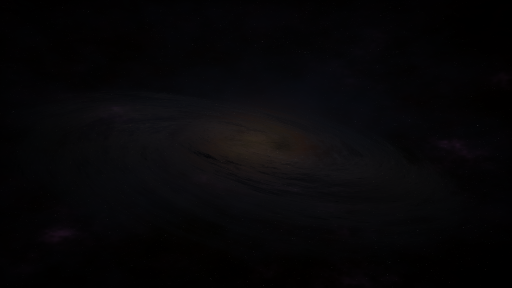
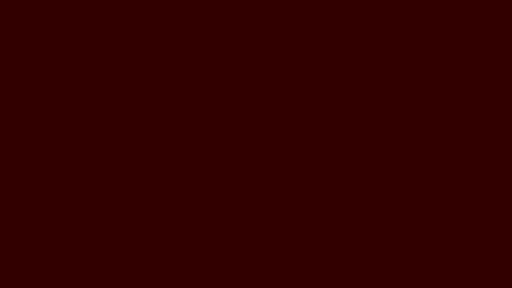

In [ ]:
# @title 5. Inspect Random Pair (Visual & Code)
import json
import random
import os
import html
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display, HTML

def image_to_base64(img):
    """Converts a PIL Image to a base64 string for HTML embedding."""
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def inspect_visual_pair():
    # 1. Config Check
    if not os.path.exists(OUTPUT_FILE):
        print(f"[!] No synthetic data found at: {OUTPUT_FILE}")
        return

    # 2. Pick Random
    with open(OUTPUT_FILE, "r") as f:
        lines = f.readlines()
        if not lines:
            print("[!] Synthetic file is empty.")
            return
        syn_data = json.loads(random.choice(lines))

    # 3. Find Parent Code
    parent_id = syn_data.get("parent_id")
    original_code = "void mainImage(out vec4 c, in vec2 f){c=vec4(1,0,0,1);}"

    if os.path.exists(INPUT_FILE):
        with open(INPUT_FILE, "r") as f:
            for line in f:
                try:
                    d = json.loads(line)
                    if d.get("id") == parent_id:
                        original_code = d.get("code", "")
                        break
                except: continue

    # 4. Render using Shared Library
    print("Rendering Original...", end="\r")
    img_orig = shader_utils.render_image(original_code, width=512, height=288)

    print("Rendering Variation...", end="\r")
    img_new = shader_utils.render_image(syn_data.get("code", ""), width=512, height=288)

    # Handle Failures (Red Placeholder)
    if img_orig is None:
        img_orig = Image.new('RGB', (512, 288), (50, 0, 0))
    if img_new is None:
        img_new = Image.new('RGB', (512, 288), (50, 0, 0))

    # 5. Convert to Base64 (The Fix)
    b64_orig = image_to_base64(img_orig)
    b64_new = image_to_base64(img_new)

    # 6. Display UI
    strategy = html.escape(syn_data.get('strategy', 'Unknown'))
    orig_code_safe = html.escape(original_code)
    new_code_safe = html.escape(syn_data.get("code", ""))

    html_ui = f"""
    <style>
        .container {{ display: flex; gap: 20px; font-family: sans-serif; }}
        .column {{ flex: 1; min-width: 0; }}
        .shader-box {{
            width: 100%; height: 300px;
            font-family: monospace; font-size: 11px; white-space: pre;
            background: #f7f7f7; border: 1px solid #ccc;
        }}
        .header {{
            background: #e8f0fe; padding: 10px;
            border-left: 5px solid #4285f4; margin-bottom: 20px;
        }}
        img {{ width: 100%; border: 1px solid #ddd; margin-bottom: 10px; }}
        h3 {{ margin: 0 0 10px 0; font-size: 14px; color: #333; }}
    </style>

    <div class="header">
        <strong>STRATEGY:</strong> {strategy}
    </div>

    <div class="container">
        <div class="column">
            <h3>ORIGINAL (ID: {parent_id[:8]})</h3>
            <img src="{b64_orig}">
            <textarea class="shader-box" readonly>{orig_code_safe}</textarea>
        </div>
        <div class="column">
            <h3>GENERATED VARIATION</h3>
            <img src="{b64_new}">
            <textarea class="shader-box" readonly>{new_code_safe}</textarea>
        </div>
    </div>
    """

    display(HTML(html_ui))

inspect_visual_pair()